In [26]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from IPython.display import clear_output
import numpy as np

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')

In [13]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

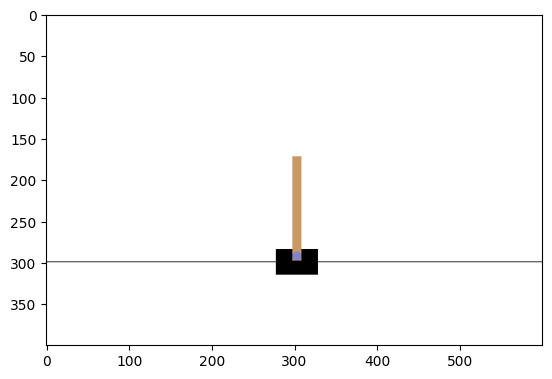

In [14]:
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [15]:
class A_C(nn.Module):
    def __init__(self, state_shape,n_actions):
        super(A_C,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(state_shape,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU()
        )
        self.critic = nn.Linear(64,1)
        self.actor = nn.Linear(64,n_actions)
        
    def forward(self,x):
        x = self.f(x)
        value = self.critic(x)
        action_prob = F.softmax(self.actor(x),dim=-1)
        pmf = Categorical(action_prob)
        return pmf,value
    
    def select_action(self,x):
        pmf,_ = self.forward(x)
        action = pmf.sample()
        return action.item()

In [45]:
Agent = A_C(4,2).to(device)
optimizer = torch.optim.Adam(Agent.parameters(),lr=3e-4)

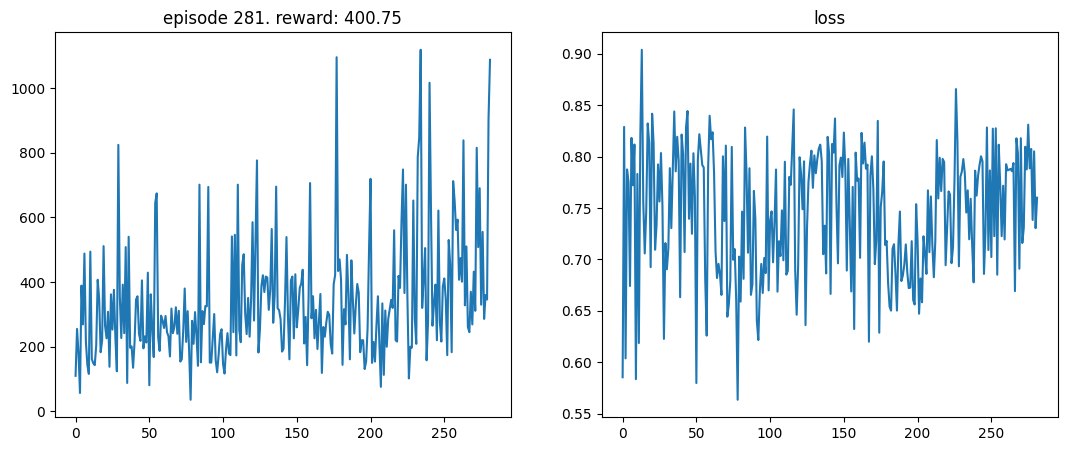

Solved


In [47]:
num_episodes = 1000
epsilon = 0.2
average_reward = []
losses = []
for episode in range(num_episodes):
    
    episode_reward = 0
    episode_rewards = []
    log_probs = []
    values = []
    returns = []
    states = []
    actions = []
    
    state,info = env.reset()
    while True:
        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
        pmf,value = Agent(state)
        action = pmf.sample()
        log_prob_action = pmf.log_prob(action)
        next_state,reward,done,_,info = env.step(action.item())
        log_probs.append(log_prob_action)
        episode_rewards.append(reward)
        values.append(value)
        states.append(state)
        actions.append(action)
        if done:
            break        
        state = next_state
        episode_reward += reward
    average_reward.append(episode_reward)
        
    g = 0
    for r in episode_rewards[::-1]:
        g = r + 0.99 * g
        returns.insert(0,g)
        
    returns = torch.tensor(returns)
    returns = (returns - returns.mean())/returns.std()
    actor_loss = []
    critic_loss = []  
    #print(len(log_probs),len(returns),len(values),len(states))
    for log_prob,r,v,s,act in zip(log_probs,returns,values,states,actions):
        a = r - v.detach()
        new_pmf,_ = Agent(s)
        new_log_prob = new_pmf.log_prob(act)
        
        ratio = (new_log_prob - log_prob.detach()).exp()
        l_1 = ratio * a
        l_2 = torch.clamp(ratio,1-epsilon,1+epsilon) * a
        l = -torch.min(l_1,l_2)
        actor_loss.append(l)
        critic_loss.append(a.pow(2))
        
    actor_loss = torch.cat(actor_loss)
    critic_loss = torch.cat(critic_loss)
    loss = actor_loss.mean()+ 0.5 * critic_loss.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
        
    plot(episode,average_reward,losses)
    if np.mean(average_reward[-100:]) > 400:
        print('Solved')
        break
        
    